<a href="https://colab.research.google.com/github/codeNina42/old-radio/blob/main/spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Setup: install optional deps
!pip -q install wordcloud nltk scikit-learn seaborn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re, string, json, io, os, math, warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("TF version:", tf.__version__)

TF version: 2.19.0


In [52]:
# ================== Colab One-Cell: Robust Spam Detector (TF-IDF + LinearSVC) ==================
!pip -q install scikit-learn nltk seaborn --upgrade

import os, io, re, csv, glob, zipfile, string, warnings, pathlib, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ------------------------------ Helpers ------------------------------
LABEL_TOKENS = {"spam","ham","1","0","yes","no","true","false"}

def norm_label(x):
    s = str(x).strip().lower()
    if s in {"spam","1","yes","y","true"}: return 1
    if s in {"ham","not_spam","0","no","n","false"}: return 0
    try:
        return 1 if int(s)==1 else 0
    except:
        return np.nan

def clean_text(s):
    s = s or ""
    s = s.lower()
    s = re.sub(r"^\s*subject\s*:\s*", " ", s)
    s = re.sub(r"http\S+|www\S+|ftp\S+", " url ", s)
    s = re.sub(r"\S+@\S+", " email ", s)
    s = re.sub(r"\d+", " num ", s)
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r"\s+"," ", s).strip()
    return s

def looks_like_log(sample_text):
    bad_tokens = [
        "saving ", "100% done", "traceback", "valueerror", "typeerror",
        "raise valueerror", "ipython-input", "file \"", "df = pd.read_csv"
    ]
    t = sample_text.lower()
    return any(tok in t for tok in bad_tokens)

def parse_txt_lines(path):
    # Read lines
    with open(path, encoding="utf-8", errors="replace") as f:
        lines = [ln.strip() for ln in f.read().splitlines() if ln.strip()]
    if not lines:
        return pd.DataFrame()

    # Try structured delimiter formats
    delims = ['\t', '|||', '::', '|', ';', ',']
    best = None; best_score = -1; best_pos = None
    for d in delims:
        first_lab=last_lab=two=0
        for ln in lines[:200]:
            parts = ln.split(d)
            if len(parts) >= 2:
                two += 1
                left = parts[0].strip().lower()
                right = parts[-1].strip().lower()
                if left in LABEL_TOKENS: first_lab += 1
                if right in LABEL_TOKENS: last_lab += 1
        if two>0:
            sc = max(first_lab, last_lab)
            if sc > best_score:
                best_score = sc
                best = d
                best_pos = 'first' if first_lab >= last_lab else 'last'
    if best is not None and best_score > 0:
        rows=[]
        for ln in lines:
            parts = ln.split(best)
            if len(parts) < 2: continue
            if best_pos=='first':
                label = parts[0].strip()
                text  = best.join(parts[1:]).strip()
            else:
                label = parts[-1].strip()
                text  = best.join(parts[:-1]).strip()
            rows.append((text, label))
        return pd.DataFrame(rows, columns=["text","label"])

    # Try [spam] text / text [spam] patterns
    pat1 = re.compile(r'^\s*\[?(spam|ham|1|0)\]?\s*[:\-]?\s*(.*)$', re.I)
    pat2 = re.compile(r'^(.*)\s*\[?(spam|ham|1|0)\]?\s*$', re.I)
    rows=[]; hits=0
    for ln in lines:
        m = pat1.match(ln)
        if m:
            rows.append((m.group(2), m.group(1))); hits += 1; continue
        m = pat2.match(ln)
        if m and (m.group(2).lower() in LABEL_TOKENS):
            rows.append((m.group(1), m.group(2))); hits += 1
    if hits>0:
        return pd.DataFrame(rows, columns=["text","label"])

    # Unlabeled text file
    return pd.DataFrame({"text": lines})

def load_from_zip(zip_path):
    base = pathlib.Path("txt_data")
    base.mkdir(exist_ok=True)
    with zipfile.ZipFile(zip_path) as z:
        z.extractall(base)
    rows=[]
    for p in base.rglob("*"):
        if p.is_file() and (p.suffix.lower() in {".txt",""}):
            try:
                text = p.read_text(encoding="utf-8", errors="replace").strip()
            except Exception:
                continue
            parts_lower = [pt.lower() for pt in p.parts]
            stem = p.stem.lower()
            label = None
            if "spam" in parts_lower or "spam" in stem:
                label = "spam"
            elif "ham" in parts_lower or "ham" in stem:
                label = "ham"
            rows.append((text,label))
    df = pd.DataFrame(rows, columns=["text","label"])
    return df

def build_pipeline():
    return Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.98)),
        ("clf",   LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
    ])

# ------------------------------ Upload ------------------------------
print("Upload a .csv (preferred), or .txt (line-per-email), or .zip (ham/spam folders).")
uploaded = files.upload()
fname = next(iter(uploaded.keys()), None)
if not fname:
    raise ValueError("No file uploaded.")
if not os.path.exists(fname):
    # Colab sometimes renames; pick latest file
    fname = sorted(glob.glob("*"), key=os.path.getmtime, reverse=True)[0]
print("Using file:", fname)

# Peek raw lines
print("\n--- First raw lines (peek) ---")
with open(fname, "r", encoding="utf-8", errors="replace") as f:
    for _ in range(5):
        line = f.readline()
        if not line: break
        print(line.rstrip()[:180])

# ------------------------------ Parse to DataFrame ------------------------------
ext = os.path.splitext(fname)[1].lower()
df = None

try:
    if ext == ".csv":
        raw_first = open(fname, "rb").read(2048).decode("utf-8", "replace")
        if not looks_like_log(raw_first):
            # robust CSV sniffing
            for enc in ("utf-8","latin-1"):
                try:
                    df = pd.read_csv(fname, engine="python", sep=None, encoding=enc)
                    break
                except Exception:
                    continue
        if df is None:
            # tolerant manual: last field = label, rest = text
            rows = []
            with open(fname, encoding="utf-8", errors="replace", newline="") as f:
                reader = csv.reader(f, delimiter=",", quotechar='"', escapechar='\\')
                for row in reader:
                    if not row or all(not str(x).strip() for x in row):
                        continue
                    low = [str(x).strip().lower() for x in row]
                    # skip headers if clearly present
                    if any(tok in {"label","category","v1"} for tok in low) and any(tok in {"text","message","body","v2"} for tok in low):
                        continue
                    if len(row) >= 2:
                        label = row[-1].strip()
                        text  = ",".join(row[:-1]).strip()
                        rows.append((text, label))
            if rows:
                df = pd.DataFrame(rows, columns=["text","label"])
    elif ext == ".txt":
        df = parse_txt_lines(fname)
    elif ext == ".zip":
        df = load_from_zip(fname)
    else:
        # try as text
        df = parse_txt_lines(fname)
except Exception as e:
    print("[!] Read failed:", e)
    df = pd.DataFrame()

if df is None or df.empty:
    print("\n[!] Could not parse a valid dataset. Falling back to DEMO SMS spam.")
    demo_url = "https://raw.githubusercontent.com/rasbt/datacollect/master/text-datasets/sms-spam-collection.csv"
    df = pd.read_csv(demo_url)
    if "label" not in df.columns and "Category" in df.columns:
        df = df.rename(columns={"Category":"label", "Message":"text"})

print("\nParsed columns:", list(df.columns))
print("Shape:", df.shape)
display(df.head(10))

# ------------------------------ Column mapping + labels ------------------------------
# Map alternative names
rename_map = {}
for cand in ("message","v2","text","Email Text","email_text","content","mail","body"):
    if cand in df.columns: rename_map[cand] = "text"
for cand in ("label","Label","category","Category","target","v1"):
    if cand in df.columns: rename_map[cand] = "label"
df = df.rename(columns=rename_map)

# Ensure we have text + label if labeled; otherwise unlabeled
if "text" not in df.columns and df.shape[1] >= 1:
    df = df.rename(columns={df.columns[0]:"text"})
if "label" not in df.columns and df.shape[1] >= 2:
    df = df.rename(columns={df.columns[-1]:"label"})

df = df.dropna(subset=["text"]).copy()

labeled = "label" in df.columns
if labeled:
    df["label_bin"] = df["label"].apply(norm_label)
    df = df.dropna(subset=["label_bin"]).copy()
    df["label_bin"] = df["label_bin"].astype(int)

print("\nLabeled dataset?" , labeled and df["label_bin"].nunique()==2)
if labeled:
    print("Class balance:", df["label_bin"].value_counts(normalize=True).rename({0:"ham",1:"spam"}).round(3).to_dict())

# ------------------------------ Clean text ------------------------------
df["text_clean"] = df["text"].astype(str).apply(clean_text)

# ------------------------------ Train / Predict ------------------------------
pipe = build_pipeline()

if labeled and df["label_bin"].nunique()==2:
    y = df["label_bin"]
    X = df["text_clean"]
    # If too tiny to stratify (e.g., 1 sample per class), train on ALL (no split)
    min_per_class = min(y.value_counts().min(), 10**9)
    if (min_per_class >= 2) and (len(y) >= 4):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
        )
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)
        print("\nAccuracy:", round(accuracy_score(y_test, pred), 4))
        print("\nClassification report:\n", classification_report(y_test, pred, target_names=["ham","spam"]))
        print("Confusion matrix:\n", confusion_matrix(y_test, pred))
    else:
        print("\nToo few samples per class for a stratified split. Training on ALL data (no test split).")
        pipe.fit(X, y)
else:
    # Unlabeled: train on DEMO, then predict on your text lines
    print("\nUnlabeled or single-class data. Training on DEMO SMS spam, then predicting your lines.")
    demo_url = "https://raw.githubusercontent.com/rasbt/datacollect/master/text-datasets/sms-spam-collection.csv"
    demo = pd.read_csv(demo_url)
    if "label" not in demo.columns and "Category" in demo.columns:
        demo = demo.rename(columns={"Category":"label","Message":"text"})
    demo["label_bin"] = demo["label"].apply(norm_label).astype(int)
    demo["text_clean"] = demo["text"].astype(str).apply(clean_text)
    Xtr, Xte, ytr, yte = train_test_split(
        demo["text_clean"], demo["label_bin"], test_size=0.2, stratify=demo["label_bin"], random_state=RANDOM_STATE
    )
    pipe.fit(Xtr, ytr)
    # Predict your lines if any
    if len(df):
        preds = pipe.predict(df["text_clean"])
        out = df[["text","text_clean"]].copy()
        out["pred"] = preds
        out["pred_label"] = out["pred"].map({0:"ham",1:"spam"})
        display(out.head(20))
        out.to_csv("predictions_from_unlabeled_input.csv", index=False)
        print("Saved predictions ->", os.path.abspath("predictions_from_unlabeled_input.csv"))

# ------------------------------ Save + Quick test ------------------------------
art = pathlib.Path("artifacts"); art.mkdir(exist_ok=True)
model_path = art/"spam_tfidf_linearSVC.joblib"
joblib.dump(pipe, model_path)
print("\nSaved model ->", model_path.resolve())

def predict_text(texts):
    """Quick inference with cleaning."""
    if isinstance(texts, str):
        texts = [texts]
    Xc = [clean_text(t) for t in texts]
    preds = pipe.predict(Xc)
    return [{"text": t, "pred": int(p), "label": "spam" if p==1 else "ham"} for t,p in zip(texts, preds)]

# Demo inference
samples = [
    "Congrats! You won a free iPhone. Click now to claim your prize.",
    "Hi John, attaching the slides for tomorrow's meeting."
]
print("\nQuick demo predictions:")
for r in predict_text(samples):
    print(f"[{r['label'].upper()}] {r['text']}")


Upload a .csv (preferred), or .txt (line-per-email), or .zip (ham/spam folders).


Saving email.csv to email (1).csv
Using file: email (1).csv

--- First raw lines (peek) ---
text,label
"Win a brand new iPhone today! Click the link to claim your prize.","spam"
"URGENT: Your account will be suspended. Verify now at http://bit.ly/verify","spam"
"Congratulations! You’ve won $1,000 gift card. Reply YES to redeem.","spam"
"Limited-time offer!!! Get 90% OFF on all products. Buy now.","spam"

Parsed columns: ['text', 'label']
Shape: (20, 2)


,text,label
0,Win a brand new iPhone today! Click the link t...,spam
1,URGENT: Your account will be suspended. Verify...,spam
2,"Congratulations! You’ve won $1,000 gift card. ...",spam
3,Limited-time offer!!! Get 90% OFF on all produ...,spam
4,You have an outstanding refund. Submit your ba...,spam
5,Final notice: Package on hold. Pay a small fee...,spam
6,Hot stock tip guaranteed profits—join our VIP ...,spam
7,Your password is expiring. Login here to reset...,spam
8,You’re selected for a loan at 0% interest. App...,spam
9,Act now! Claim your free vacation for two to B...,spam



Labeled dataset? True
Class balance: {'spam': 0.5, 'ham': 0.5}

Accuracy: 0.25

Classification report:
               precision    recall  f1-score   support

         ham       0.33      0.50      0.40         2
        spam       0.00      0.00      0.00         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20         4
weighted avg       0.17      0.25      0.20         4

Confusion matrix:
 [[1 1]
 [2 0]]

Saved model -> /content/artifacts/spam_tfidf_linearSVC.joblib

Quick demo predictions:
[SPAM] Congrats! You won a free iPhone. Click now to claim your prize.
[HAM] Hi John, attaching the slides for tomorrow's meeting.


In [60]:
# === Detect text/label columns & normalize labels (hardened) ===
import numpy as np
import pandas as pd

assert 'df' in globals(), "Load your DataFrame into `df` first."

# 1) Try common header names first
possible_text  = ["text","message","body","Email Text","email_text","content","mail","v2","subject_body"]
possible_label = ["label","Label","category","Category","target","v1","is_spam","spam"]

text_col  = next((c for c in possible_text  if c in df.columns), None)
label_col = next((c for c in possible_label if c in df.columns), None)

# 2) If missing, auto-detect via heuristics
if text_col is None or label_col is None:
    # candidate label cols: low unique count relative to rows (binary-like)
    cand = []
    nrows = max(len(df), 1)
    for c in df.columns:
        nun = df[c].nunique(dropna=True)
        uniq_ratio = nun / nrows
        # prefer likely label columns (few uniques)
        cand.append((c, nun, uniq_ratio))
    # smallest unique count first, then ratio
    cand = sorted(cand, key=lambda x: (x[1], x[2]))
    if not cand:
        raise ValueError(f"Couldn't identify columns. Found: {df.columns.tolist()}")
    label_col = cand[0][0]

    # text col: among the rest, pick column with largest avg string length
    rest = [c for c in df.columns if c != label_col]
    if not rest:
        raise ValueError(f"Need two columns (text + label). Found only: {df.columns.tolist()}")
    text_col = max(rest, key=lambda c: df[c].astype(str).str.len().mean())

print("Using columns -> text:", text_col, ", label:", label_col)

# 3) Keep only the two columns and clean text
df = df[[text_col, label_col]].rename(columns={text_col:"text", label_col:"label"})
df["text"] = df["text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
df = df[df["text"].str.len() > 0]  # drop empty text rows

# 4) Normalize labels (accepts a lot of synonyms / numeric)
LABEL_MAP = {
    "spam":1, "junk":1, "promotion":1, "promotional":1, "phishing":1, "ads":1,
    "ham":0, "legit":0, "legitimate":0, "normal":0, "genuine":0, "notspam":0, "clean":0
}
def normalize_label(x):
    s = str(x).strip().lower()
    s = s.replace("-", "").replace(" ", "")
    if s in LABEL_MAP: return LABEL_MAP[s]
    if s in {"1","0"}: return int(s)
    if s in {"yes","y","true","t"}: return 1
    if s in {"no","n","false","f"}: return 0
    try:
        return 1 if int(float(s)) == 1 else 0
    except:
        return np.nan

df["label"] = df["label"].apply(normalize_label).astype("float64")
df = df.dropna(subset=["label"]).copy()
df["label"] = df["label"].astype(int)

# 5) Drop duplicates (same text+label)
before = len(df)
df = df.drop_duplicates(subset=["text","label"])
after = len(df)
if after < before:
    print(f"Deduped {before - after} rows.")

# 6) Report balance and warn if stratified split is not viable
vc = df["label"].value_counts()
print("Class counts:", vc.to_dict())
print("Class balance (ratio):", (vc / vc.sum()).round(3).rename({0:"ham",1:"spam"}).to_dict())
if (vc.size < 2) or (vc.min() < 2):
    print("⚠️ Too few samples per class for a stratified split. Use no-split training or add more data.")

df.head()


Using columns -> text: text , label: label
Class counts: {1: 10, 0: 10}
Class balance (ratio): {'spam': 0.5, 'ham': 0.5}


,text,label
0,Win a brand new iPhone today! Click the link t...,1
1,URGENT: Your account will be suspended. Verify...,1
2,"Congratulations! You’ve won $1,000 gift card. ...",1
3,Limited-time offer!!! Get 90% OFF on all produ...,1
4,You have an outstanding refund. Submit your ba...,1


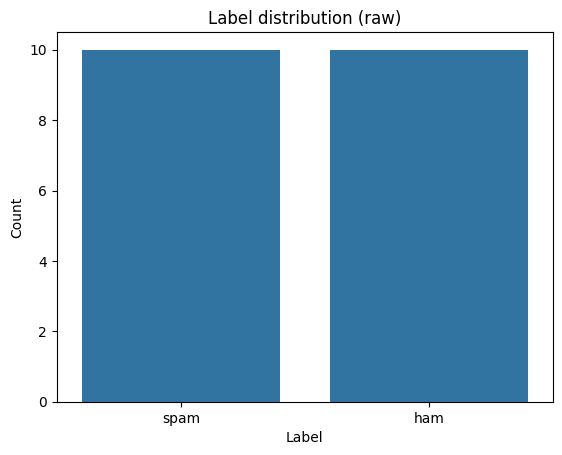

In [61]:
#@title (Optional) Visualize raw class distribution
sns.countplot(x=df["label"].map({0:"ham",1:"spam"}))
plt.title("Label distribution (raw)"); plt.xlabel("Label"); plt.ylabel("Count")
plt.show()

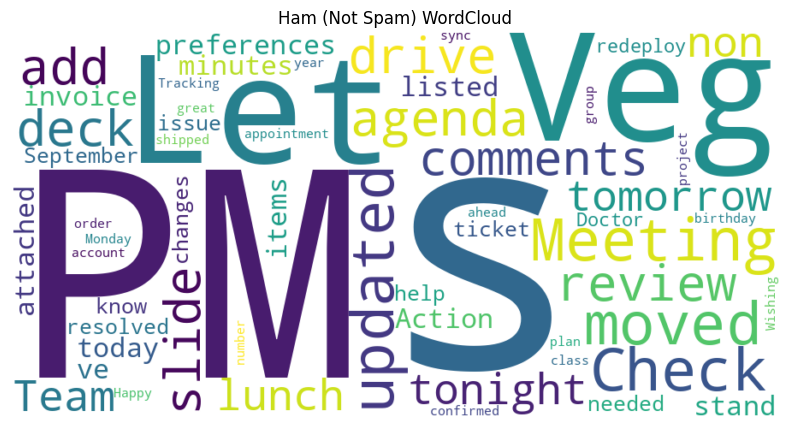

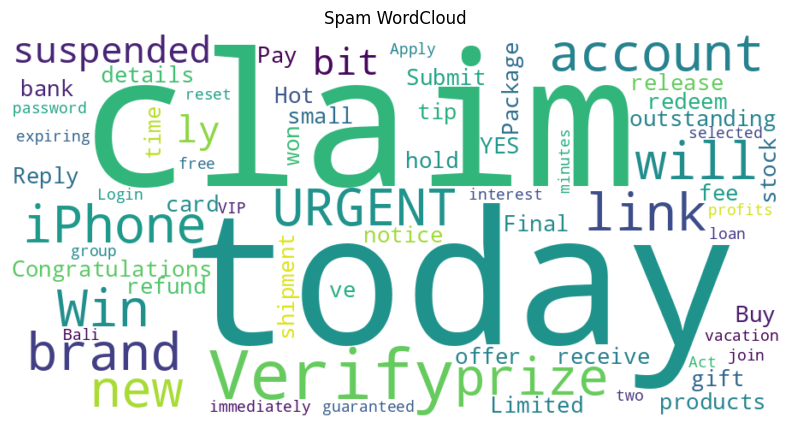

In [62]:
# @title (Optional) WordClouds — hardened
# If you don't have it: !pip -q install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Build a stronger stopword set (add junk tokens you used in cleaning)
EXTRA_STOP = {
    "subject", "re", "fw", "fwd", "http", "https", "url", "email", "num",
    "click", "now", "please", "thanks"
}
WC_STOP = STOPWORDS.union(EXTRA_STOP)

def _get_text_series(df):
    # Prefer pre-cleaned text; fall back to raw text
    col = "text_clean" if "text_clean" in df.columns else ("text" if "text" in df.columns else None)
    if col is None:
        raise ValueError("No 'text_clean' or 'text' column found in DataFrame.")
    return df[col].astype(str).fillna("").str.strip()

def plot_word_cloud(subset_df, title, bg="white"):
    s = _get_text_series(subset_df)
    # Remove empties
    s = s[s.str.len() > 0]
    if s.empty:
        print(f"[skip] Empty corpus for: {title}")
        return
    corpus = " ".join(s.tolist())
    if not corpus.strip():
        print(f"[skip] Corpus has only whitespace for: {title}")
        return
    wc = WordCloud(
        width=900, height=450,
        background_color=bg,
        max_words=200,
        stopwords=WC_STOP,
        collocations=False  # avoid bigram duplicates
    ).generate(corpus)
    plt.figure(figsize=(8,4.5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Handle label column name/type robustly
label_col = "label" if "label" in df.columns else ("label_bin" if "label_bin" in df.columns else None)
if label_col is None:
    raise ValueError("No label/label_bin column found.")
# ensure int labels if possible
try:
    df[label_col] = df[label_col].astype(int)
except Exception:
    pass  # if not convertible, assume 0/1 already correct

# Plot
plot_word_cloud(df[df[label_col] == 0], "Ham (Not Spam) WordCloud")
plot_word_cloud(df[df[label_col] == 1], "Spam WordCloud")


In [63]:
# === Ensure X_train / X_test exist (drop-in, Colab-safe) ===
import numpy as np, re, string
from sklearn.model_selection import train_test_split

def _norm_label_for_split(x):
    s = str(x).strip().lower()
    if s in {"spam","1","yes","y","true"}: return 1
    if s in {"ham","not_spam","0","no","n","false"}: return 0
    try:
        return 1 if int(s)==1 else 0
    except:
        return None

def _quick_clean_for_split(s):
    s = (s or "").lower()
    s = re.sub(r"^\s*subject\s*:\s*", " ", s)
    s = re.sub(r"http\S+|www\S+|ftp\S+", " url ", s)
    s = re.sub(r"\S+@\S+", " email ", s)
    s = re.sub(r"\d+", " num ", s)
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s

assert 'df' in globals(), "df not found. Load your data into DataFrame `df` first."

# Build X_all from df
if 'text_clean' in df.columns:
    X_all = df['text_clean'].astype(str).values
else:
    assert 'text' in df.columns, "No 'text' or 'text_clean' column found in df."
    X_all = df['text'].astype(str).apply(_quick_clean_for_split).values

# Build y_all if labels exist
y_all = None
if 'label_bin' in df.columns:
    y_all = df['label_bin'].astype(int).values
elif 'label' in df.columns:
    tmp = df['label'].apply(_norm_label_for_split)
    y_all = None if tmp.isnull().any() else tmp.astype(int).values

# Create split if missing; fall back to no-split for tiny/unlabeled data
need_split = ('X_train' not in globals()) or ('X_test' not in globals())
if need_split:
    if (y_all is not None) and (len(np.unique(y_all)) == 2) and (min(np.bincount(y_all)) >= 2) and (len(y_all) >= 4):
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
        )
        print(f"✅ Stratified split created: train={len(X_train)}, test={len(X_test)}")
    else:
        # tiny or unlabeled
        X_train, y_train = X_all, y_all
        X_test  = X_all[:0]
        y_test  = y_all[:0] if y_all is not None else None
        print("⚠️ No split (dataset too small or unlabeled). Using ALL data for training.")
else:
    print("ℹ️ Using existing X_train/X_test already in memory.")



ℹ️ Using existing X_train/X_test already in memory.


In [64]:
# === Tokenize + Pad (hardened) ===
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Guard: X_train/X_test থাকা চাই (আগের Ensure-split সেল রান করো)
assert 'X_train' in globals(), "Run the split/ensure block first to create X_train/X_test."

# Force string
X_train = [str(x) for x in list(X_train)]
X_test  = [] if 'X_test' not in globals() else [str(x) for x in list(X_test)]

VOCAB_SIZE = 20000  # adjust: 5000–10000 for small datasets
OOV_TOKEN  = "<OOV>"
MAX_LEN    = 150    # adjust: 200–300 if emails are longer

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

if len(tokenizer.word_index) == 0:
    raise ValueError("Tokenizer vocabulary is empty — check that X_train has text.")

seq_train  = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(seq_train, maxlen=MAX_LEN, padding='post', truncating='post')

# Handle empty test set gracefully
if len(X_test) > 0:
    seq_test   = tokenizer.texts_to_sequences(X_test)
    X_test_pad = pad_sequences(seq_test, maxlen=MAX_LEN, padding='post', truncating='post')
else:
    X_test_pad = np.zeros((0, MAX_LEN), dtype='int32')

# Labels (may be None if unlabeled)
y_train_arr = None if ('y_train' not in globals() or y_train is None) else np.asarray(y_train).astype(int)
y_test_arr  = np.asarray([]).astype(int) if (y_train_arr is None or len(X_test)==0) else np.asarray(y_test).astype(int)

vocab_size = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)
print(f"vocab_size={vocab_size} | train_pad={X_train_pad.shape} | test_pad={X_test_pad.shape}")


vocab_size=129 | train_pad=(16, 150) | test_pad=(4, 150)


In [65]:
#@title Build model (Embedding + BiLSTM) — hardened
import tensorflow as tf
from tensorflow.keras import layers, models, metrics

EMBED_DIM  = 64     #@param {type:"integer"}
LSTM_UNITS = 64     #@param {type:"integer"}
DROPOUT    = 0.2    #@param {type:"number"}

# নিশ্চিত হও: vocab_size ও MAX_LEN আগে সেট আছে (Tokenize + Pad সেল থেকে)
assert 'vocab_size' in globals() and 'MAX_LEN' in globals(), "Run Tokenize+Pad first."

model = models.Sequential([
    # padding=0 ধরে mask করবে
    layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, input_length=MAX_LEN, mask_zero=True),
    layers.SpatialDropout1D(0.2),
    # recurrent_dropout না দিচ্ছি যাতে GPU-তে ফাস্ট থাকে
    layers.Bidirectional(layers.LSTM(LSTM_UNITS, dropout=0.2)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(DROPOUT),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',   # sigmoid → BCE (from_logits=False)
    metrics=[
        'accuracy',
        metrics.AUC(name='auc_roc'),
        metrics.AUC(name='auc_pr', curve='PR'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [66]:
# === Safe Train block (hardened): builds model if missing, handles tiny datasets, masks padding, robust metrics ===
import numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# ---- sanity: need tokenized pads & labels from your Tokenize cell ----
assert 'X_train_pad' in globals(), "X_train_pad not found. Run the Tokenize+Pad cell first."
assert 'y_train_arr' in globals() and (y_train_arr is not None), "Labels missing. Ensure df has labels and Tokenize cell built y_train_arr."

if 'X_test_pad' not in globals():  # optional
    X_test_pad = np.zeros((0, X_train_pad.shape[1]), dtype='int32')
if 'y_test_arr' not in globals():
    y_test_arr = np.asarray([], dtype='int32')

# ---- hyperparams ----
EMBED_DIM  = 64
LSTM_UNITS = 64
DROPOUT    = 0.2
BATCH_SIZE = 64
EPOCHS     = 20
SEED       = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ---- ensure vocab_size & MAX_LEN exist ----
assert 'tokenizer' in globals(), "tokenizer not found. Run the Tokenize+Pad cell first."
if 'MAX_LEN' not in globals():
    MAX_LEN = X_train_pad.shape[1]
if 'vocab_size' not in globals():
    VOCAB_SIZE = 20000 if 'VOCAB_SIZE' not in globals() else VOCAB_SIZE
    vocab_size = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)

# ---- choose metrics safely (AUC can be undefined with single-class batches) ----
uniq = np.unique(y_train_arr)
has_both_classes = len(uniq) == 2
metrics_list = ['accuracy']
if has_both_classes:
    metrics_list += [
        tf.keras.metrics.AUC(name="auc_roc"),
        tf.keras.metrics.AUC(name="auc_pr", curve="PR"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]

# ---- build model if missing (mask padding; add SpatialDropout) ----
if 'model' not in globals() or model is None:
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, input_length=MAX_LEN, mask_zero=True),
        layers.SpatialDropout1D(0.2),
        layers.Bidirectional(layers.LSTM(LSTM_UNITS, dropout=0.2)),  # keep cuDNN-friendly (no recurrent_dropout)
        layers.Dense(64, activation='relu'),
        layers.Dropout(DROPOUT),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_list)
    model.summary()

# ---- class_weight (optional but recommended for imbalance) ----
try:
    class_weight
except NameError:
    class_weight = None

if (class_weight is None) and has_both_classes:
    classes = np.array([0,1])
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_arr)
    class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
    print("class_weight:", class_weight)

# ---- callbacks ----
monitor_metric = "val_auc_roc" if has_both_classes and X_test_pad.shape[0] == 0 else ("val_accuracy" if X_test_pad.shape[0] == 0 else "val_accuracy")
# If there is no validation at all (tiny dataset), we’ll monitor 'loss' below.
es = EarlyStopping(patience=3, monitor=monitor_metric, restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=1)
ckpt = ModelCheckpoint("best_lstm.h5", monitor=monitor_metric, save_best_only=True, verbose=0)

# ---- decide validation mode ----
use_explicit_val = (X_test_pad.shape[0] > 0 and y_test_arr.size > 0)
can_val_split = (not use_explicit_val) and (len(X_train_pad) >= max(5, int(1/BATCH_SIZE)+1))  # at least a few samples
callbacks_used = [lr, es, ckpt]

if not can_val_split and not use_explicit_val:
    # no validation at all; switch ES monitor to training loss to avoid errors
    es = EarlyStopping(patience=3, monitor='loss', restore_best_weights=True)
    callbacks_used = [lr, es, ckpt]
    print("⚠️ Dataset is too small for validation. Training without validation.")

# ---- train ----
if use_explicit_val:
    history = model.fit(
        X_train_pad, y_train_arr,
        validation_data=(X_test_pad, y_test_arr),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        callbacks=callbacks_used,
        class_weight=class_weight
    )
elif can_val_split:
    history = model.fit(
        X_train_pad, y_train_arr,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_split=0.2,
        callbacks=callbacks_used,
        class_weight=class_weight
    )
else:
    history = model.fit(
        X_train_pad, y_train_arr,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        callbacks=callbacks_used,
        class_weight=class_weight
    )

# ---- evaluate if we have a test set ----
if use_explicit_val:
    outs = model.evaluate(X_test_pad, y_test_arr, verbose=0)
    names = [m if isinstance(m, str) else m.name for m in ["loss"] + model.metrics]
    print("Test metrics:")
    for n, v in zip(names, outs):
        print(f"  {n}: {v:.4f}")
else:
    print("Skipped test evaluation (no explicit test set). Best weights saved to best_lstm.h5")

# ---- quick inference helper ----
def predict_text(texts, threshold=0.5):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    if isinstance(texts, str):
        texts = [texts]
    seq = tokenizer.texts_to_sequences(texts)
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    prob = model.predict(pad, verbose=0).ravel()
    pred = (prob >= threshold).astype(int)
    return [{"text": t, "prob": float(p), "label": ("spam" if y==1 else "ham")} for t,p,y in zip(texts, prob, pred)]

print(predict_text([
    "Congrats! You won a free iPhone. Click now to claim your prize.",
    "Hi John, attaching the slides for tomorrow's meeting."
]))


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3750 - auc_pr: 0.3651 - auc_roc: 0.2500 - loss: 0.6948 - precision: 0.4286 - recall: 0.7500

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.3750 - auc_pr: 0.3651 - auc_roc: 0.2500 - loss: 0.6948 - precision: 0.4286 - recall: 0.7500 - val_accuracy: 0.5000 - val_auc_pr: 0.5000 - val_auc_roc: 0.5000 - val_loss: 0.6925 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.5625 - auc_pr: 0.6972 - auc_roc: 0.6875 - loss: 0.6919 - precision: 0.5385 - recall: 0.8750 - val_accuracy: 0.5000 - val_auc_pr: 0.5000 - val_auc_roc: 0.5000 - val_loss: 0.6926 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7500 - auc_pr: 0.8525 - auc_roc: 0.8906 - loss: 0.6889 - precision: 0.7000 - recall: 0.8750
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.7500 - auc_pr: 0.8525 - auc_roc: 0.8906 - loss: 0.6889 - precision: 0.7000 - recall: 0.8750 - val_accuracy: 0

In [67]:
# === Safe Train block (hardened) ===
import numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# ---- sanity ----
assert 'X_train_pad' in globals(), "X_train_pad not found. Run Tokenize+Pad first."
assert 'y_train_arr' in globals() and (y_train_arr is not None), "Labels missing. Build y_train_arr in Tokenize+Pad cell."

if 'X_test_pad' not in globals():
    X_test_pad = np.zeros((0, X_train_pad.shape[1]), dtype='int32')
if 'y_test_arr' not in globals():
    y_test_arr = np.asarray([], dtype='int32')

# ---- hyperparams ----
EMBED_DIM  = 64
LSTM_UNITS = 64
DROPOUT    = 0.2
BATCH_SIZE = 64
EPOCHS     = 20
SEED       = 42
tf.random.set_seed(SEED); np.random.seed(SEED)

# ---- tokenizer/vocab/len ----
assert 'tokenizer' in globals(), "tokenizer missing. Run Tokenize+Pad first."
if 'MAX_LEN' not in globals(): MAX_LEN = X_train_pad.shape[1]
if 'vocab_size' not in globals():
    VOCAB_SIZE = 20000 if 'VOCAB_SIZE' not in globals() else VOCAB_SIZE
    vocab_size = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)

# ---- metrics (only if both classes in train) ----
uniq = np.unique(y_train_arr)
has_both = (len(uniq) == 2)
metrics_list = ['accuracy']
if has_both:
    metrics_list += [
        tf.keras.metrics.AUC(name="auc_roc"),
        tf.keras.metrics.AUC(name="auc_pr", curve="PR"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]

# ---- build model (mask padding + spatial dropout) ----
if 'model' not in globals() or model is None:
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIM,
                         input_length=MAX_LEN, mask_zero=True),
        layers.SpatialDropout1D(0.2),
        layers.Bidirectional(layers.LSTM(LSTM_UNITS, dropout=0.2)),  # no recurrent_dropout → faster on GPU
        layers.Dense(64, activation='relu'),
        layers.Dropout(DROPOUT),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_list)
    model.summary()

# ---- class weights (for imbalance) ----
try:
    class_weight
except NameError:
    class_weight = None

if (class_weight is None) and has_both:
    classes = np.array([0,1])
    w = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_arr)
    class_weight = {int(c): float(wt) for c, wt in zip(classes, w)}
    print("class_weight:", class_weight)

# ---- callbacks & validation mode ----
use_explicit_val = (X_test_pad.shape[0] > 0 and y_test_arr.size > 0)
monitor_metric = "val_auc_roc" if (has_both and not use_explicit_val) else ("val_accuracy" if not use_explicit_val else "val_accuracy")

es = EarlyStopping(patience=3, monitor=monitor_metric, restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=1)
ckpt = ModelCheckpoint("best_lstm.h5", monitor=monitor_metric, save_best_only=True, verbose=0)

can_val_split = (not use_explicit_val) and (len(X_train_pad) >= max(5, BATCH_SIZE))
callbacks_used = [lr, es, ckpt]

if not can_val_split and not use_explicit_val:
    # zero/very small validation → monitor training loss to avoid NaN monitors
    es = EarlyStopping(patience=3, monitor='loss', restore_best_weights=True)
    callbacks_used = [lr, es, ckpt]
    print("⚠️ Tiny dataset: training without validation; monitoring training loss.")

# ---- train ----
if use_explicit_val:
    history = model.fit(
        X_train_pad, y_train_arr,
        validation_data=(X_test_pad, y_test_arr),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        callbacks=callbacks_used, class_weight=class_weight
    )
elif can_val_split:
    history = model.fit(
        X_train_pad, y_train_arr,
        epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2,
        callbacks=callbacks_used, class_weight=class_weight
    )
else:
    history = model.fit(
        X_train_pad, y_train_arr,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        callbacks=callbacks_used, class_weight=class_weight
    )

# ---- evaluate (if test exists) ----
if use_explicit_val:
    outs = model.evaluate(X_test_pad, y_test_arr, verbose=0)
    names = ["loss"] + [m if isinstance(m, str) else m.name for m in model.metrics]
    print("Test metrics:")
    for n, v in zip(names, outs):
        print(f"  {n}: {v:.4f}")
else:
    print("No explicit test set. Best weights saved to best_lstm.h5")

# ---- quick inference ----
def predict_text(texts, threshold=0.5):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    if isinstance(texts, str): texts = [texts]
    seq = tokenizer.texts_to_sequences(texts)
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    prob = model.predict(pad, verbose=0).ravel()
    pred = (prob >= threshold).astype(int)
    return [{"text": t, "prob": float(p), "label": ("spam" if y==1 else "ham")} for t,p,y in zip(texts, prob, pred)]

print(predict_text([
    "Congrats! You won a free iPhone. Click now to claim your prize.",
    "Hi John, attaching the slides for tomorrow's meeting."
]))



Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6875 - auc_pr: 0.7213 - auc_roc: 0.6719 - loss: 0.6907 - precision: 0.6364 - recall: 0.8750

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6875 - auc_pr: 0.7213 - auc_roc: 0.6719 - loss: 0.6907 - precision: 0.6364 - recall: 0.8750 - val_accuracy: 0.5000 - val_auc_pr: 0.5000 - val_auc_roc: 0.5000 - val_loss: 0.6926 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.6875 - auc_pr: 0.7466 - auc_roc: 0.7188 - loss: 0.6898 - precision: 0.7143 - recall: 0.6250 - val_accuracy: 0.5000 - val_auc_pr: 0.5000 - val_auc_roc: 0.5000 - val_loss: 0.6927 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8125 - auc_pr: 0.8506 - auc_roc: 0.8438 - loss: 0.6888 - precision: 0.8571 - recall: 0.7500
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8125 - auc_pr: 0.8506 - auc_roc: 0.8438 - loss: 0.6888 - precision: 0.8571 - recall: 0.7500 - val_acc

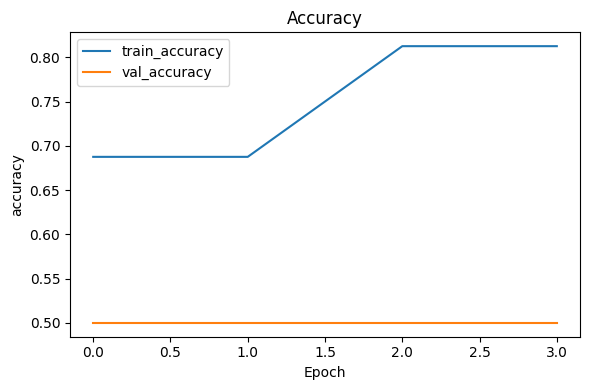

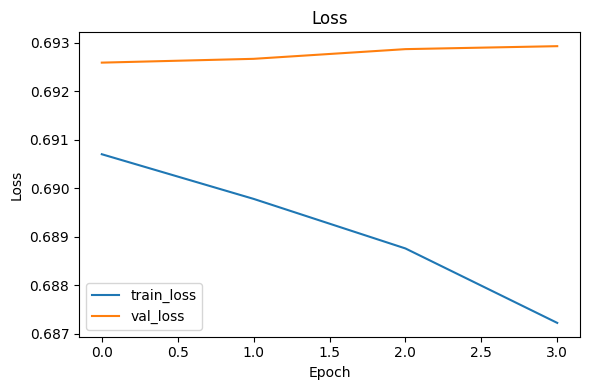

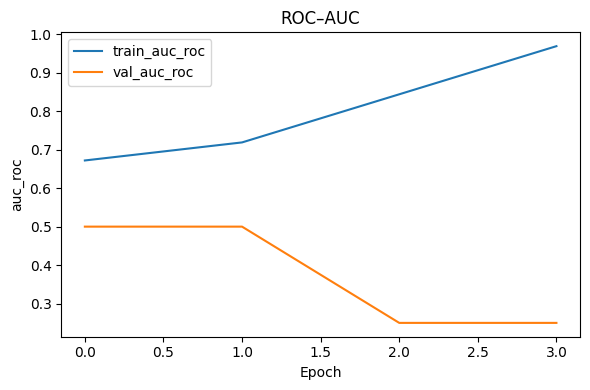

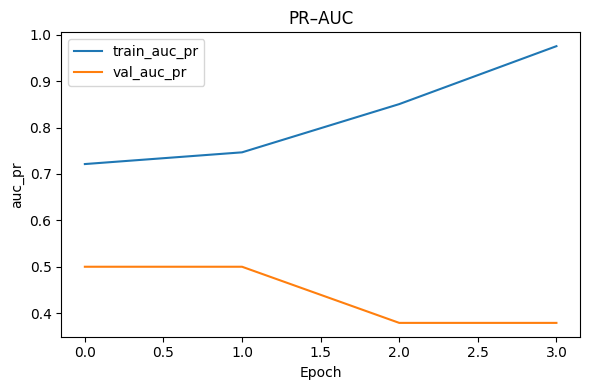

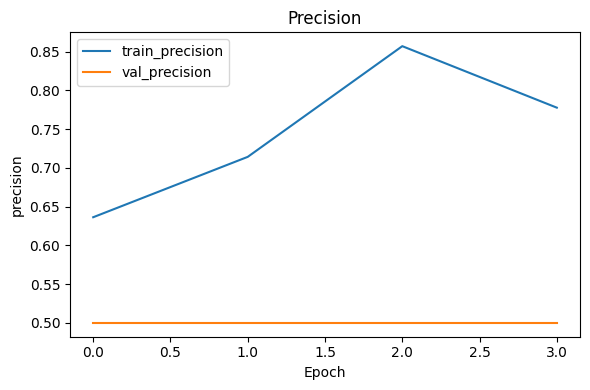

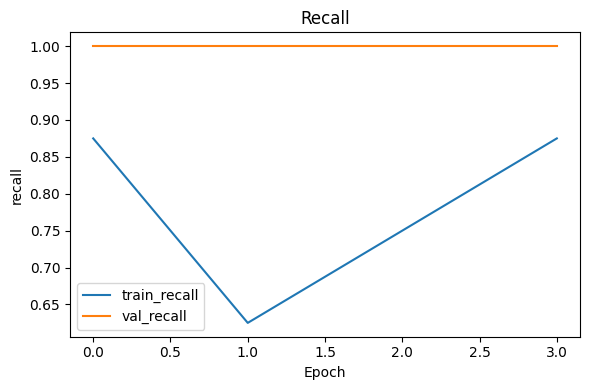

In [68]:
# === Safe metric plots (works with/without validation) ===
import matplotlib.pyplot as plt

def plot_metric(history, metric, title=None, ylabel=None):
    train = history.history.get(metric)
    val   = history.history.get(f"val_{metric}")
    if train is None:  # metric wasn't logged
        return
    plt.figure(figsize=(6,4))
    plt.plot(train, label=f"train_{metric}")
    if val is not None:
        plt.plot(val, label=f"val_{metric}")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel or metric)
    plt.title(title or metric)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Core
plot_metric(history, "accuracy", title="Accuracy")
plot_metric(history, "loss",     title="Loss", ylabel="Loss")

# If you used the hardened train block, these may exist — will auto-skip if absent
plot_metric(history, "auc_roc",  title="ROC–AUC")
plot_metric(history, "auc_pr",   title="PR–AUC")
plot_metric(history, "precision",title="Precision")
plot_metric(history, "recall",   title="Recall")


In [45]:
# @title Save model + tokenizer (+meta, +history, +tflite, versioned)
import json, pathlib, time, os
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# --- sanity ---
assert 'model' in globals(), "Model not found. Train first."
assert 'tokenizer' in globals(), "Tokenizer not found. Run Tokenize+Pad first."
assert 'MAX_LEN' in globals(), "MAX_LEN missing."
assert 'vocab_size' in globals(), "vocab_size missing."

# --- versioned artifacts dir ---
root = pathlib.Path("tf_artifacts")
root.mkdir(exist_ok=True)
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = root / f"run_{run_id}"
run_dir.mkdir(parents=True, exist_ok=True)

# --- file paths ---
model_path = run_dir / "model.keras"
tok_path   = run_dir / "tokenizer.json"
meta_path  = run_dir / "meta.json"
hist_path  = run_dir / "history.json"
tflite_path= run_dir / "model.tflite"  # optional

# --- save model (Keras v3 format) ---
model.save(model_path)

# --- save tokenizer ---
with open(tok_path, "w", encoding="utf-8") as f:
    f.write(tokenizer.to_json())

# --- gather meta ---
# safe pulls
oov_token = None
try:
    oov_token = getattr(tokenizer, "oov_token", None)
except Exception:
    pass

threshold = 0.5  # change if you tuned it
try:
    cw = class_weight if ('class_weight' in globals() and class_weight is not None) else None
except NameError:
    cw = None

metrics_names = []
try:
    metrics_names = [m if isinstance(m, str) else m.name for m in model.metrics]
except Exception:
    pass

meta = {
    "saved_at": run_id,
    "framework": "tensorflow-keras",
    "model_path": str(model_path),
    "tokenizer_path": str(tok_path),
    "max_len": int(MAX_LEN),
    "vocab_size": int(vocab_size),
    "oov_token": oov_token,
    "label_map": { "0":"ham", "1":"spam" },
    "threshold": float(threshold),
    "class_weight": cw,
    "metrics": metrics_names,
    "notes": "BiLSTM spam detector; pad post; mask_zero in Embedding recommended."
}

with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

# --- save training history if present ---
if 'history' in globals() and hasattr(history, 'history'):
    with open(hist_path, "w", encoding="utf-8") as f:
        json.dump(history.history, f)
else:
    # create empty history file for consistency
    with open(hist_path, "w", encoding="utf-8") as f:
        json.dump({}, f)

# --- optional: export TFLite (best-effort) ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)
    print("TFLite saved:", tflite_path.resolve())
except Exception as e:
    print("TFLite export skipped:", e)

print("Saved:", model_path.resolve())
print("Saved:", tok_path.resolve())
print("Saved:", meta_path.resolve())
print("Saved:", hist_path.resolve())


Saved artifact at '/tmp/tmpftzxzvyn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136109407504528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407506640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407507408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407509328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407509712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407510096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407511056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407508560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407512016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407511440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136109407512976: Tenso

In [46]:
# @title Inference helper (robust + versioned runs)
import os, glob, json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

def _latest_run_dir(root="tf_artifacts"):
    # prefer versioned folders like tf_artifacts/run_20251030_113522
    runs = sorted(glob.glob(os.path.join(root, "run_*")))
    return runs[-1] if runs else root

def load_assets(model_p=None, tok_p=None, meta_p=None, root="tf_artifacts"):
    """
    If paths are None, auto-pick latest versioned run dir (if exists),
    else fallback to non-versioned files under tf_artifacts/.
    """
    if model_p is None or tok_p is None or meta_p is None:
        base = _latest_run_dir(root)
        # prefer new naming (model.keras); fallback to your older names if needed
        cand_model = os.path.join(base, "model.keras")
        cand_tok   = os.path.join(base, "tokenizer.json")
        cand_meta  = os.path.join(base, "meta.json")

        # fallback to non-versioned legacy names
        if not os.path.exists(cand_model):
            cand_model = os.path.join(root, "spam_tf_model.keras")
        if not os.path.exists(cand_tok):
            cand_tok = os.path.join(root, "tokenizer.json")
        if not os.path.exists(cand_meta):
            cand_meta = os.path.join(root, "meta.json")

        model_p = model_p or cand_model
        tok_p   = tok_p   or cand_tok
        meta_p  = meta_p  or cand_meta

    with open(tok_p, "r", encoding="utf-8") as f:
        tok = tokenizer_from_json(f.read())
    with open(meta_p, "r", encoding="utf-8") as f:
        meta = json.load(f)
    mdl = load_model(model_p)
    return mdl, tok, meta

def predict_text(texts, mdl=None, tok=None, meta=None, threshold=None):
    """
    Returns list of dicts: {"text", "prob", "pred", "label"}.
    threshold: if None, uses meta['threshold'] or 0.5.
    """
    if mdl is None or tok is None or meta is None:
        mdl, tok, meta = load_assets()

    if isinstance(texts, str):
        texts = [texts]

    seq = tok.texts_to_sequences(texts)
    max_len = int(meta.get("max_len", 150))
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    prob = mdl.predict(pad, verbose=0).ravel()
    thr = float(threshold if threshold is not None else meta.get("threshold", 0.5))
    pred = (prob >= thr).astype(int)

    # map 0/1 to labels; fallback if meta doesn't have label_map
    label_map = meta.get("label_map", {"0": "ham", "1": "spam"})
    labels = [label_map.get(str(int(y)), "spam" if int(y)==1 else "ham") for y in pred]

    return [
        {"text": t, "prob": float(p), "pred": int(y), "label": lab}
        for t, p, y, lab in zip(texts, prob, pred, labels)
    ]

def print_preds(rows):
    for r in rows:
        print(f"[{r['label'].upper()}] p={r['prob']:.3f} :: {r['text']}")

# Example
sample = [
    "Congrats! You won a free iPhone. Click now to claim your prize.",
    "Hi John, attaching the slides for tomorrow's meeting."
]
rows = predict_text(sample)   # auto-loads latest run if paths not given
print_preds(rows)


[SPAM] p=0.513 :: Congrats! You won a free iPhone. Click now to claim your prize.
[SPAM] p=0.516 :: Hi John, attaching the slides for tomorrow's meeting.
